In [1]:
import re
import math
import numpy as np
import random
import torch
from sklearn.model_selection import train_test_split
from torchinfo import summary
import time
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Нормализуем текст и разделим его на предложения

In [3]:
def normalize_and_split_sentences(file_path, file_path2):
    # Чтение содержимого файла
    with open(file_path, 'r') as file:
        content = file.read()

    # Приведение текста к нижнему регистру
    content = content.lower()

    # Удаление нежелательных символов и знаков препинания
    content = re.sub(r'[^а-яА-Я0-9\s\.?!]', '', content)

    # Удаление лишних пробелов и пробельных символов
    content = re.sub(r'\s+', ' ', content)
    
    # Разделение текста на предложения
    sentences = re.split(r'[.!?]', content)

    # Удаление пустых предложений
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Запись нормализованных предложений в файл
    with open(file_path2, 'w') as file:
        file.write('\n'.join(sentences))


In [4]:
file_path = 'text_raw.txt'
normalize_and_split_sentences(file_path, 'text_new.txt')

Определяем словарь символов

In [5]:
CHARS = 'абвгдежзийклмнопрстуфхцчшщьыъэюя1234567890 '
INDEX_TO_CHAR =  [w for w in CHARS] + ['none']
CHARS_NUM = len(INDEX_TO_CHAR)
CHAR_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_CHAR)}
MAX_LENGTH = 50
MAX_SHIFT = 15

Функция кодировки кодом Цезаря

In [6]:
def Ceasar(line, shift):
    index_line = ['none']*MAX_LENGTH
    for i in range(min(len(line), MAX_LENGTH)):
        index_line[i] = line[i]
    index_line = list(map(lambda x: CHAR_TO_INDEX.get(x, CHAR_TO_INDEX['none']), index_line))    
    for i, ch in enumerate(index_line):
        if ch not in [CHARS_NUM-1, CHARS_NUM-2]:
            index_line[i] = (ch + shift) % (len(INDEX_TO_CHAR)-2)
    return torch.tensor(index_line)


Проверим качество работы функции, ожидаем получить циклический сдвиг на 3 символа, без учёта пробелов и none элементов

In [7]:
work_test = ' абвг эюя 890'
res = Ceasar(work_test, 3)
print(f' Тестируем работу на стоке {list(work_test)}, \n получаем {list(map(lambda x: INDEX_TO_CHAR[x], res))}')

 Тестируем работу на стоке [' ', 'а', 'б', 'в', 'г', ' ', 'э', 'ю', 'я', ' ', '8', '9', '0'], 
 получаем [' ', 'г', 'д', 'е', 'ж', ' ', '1', '2', '3', ' ', 'а', 'б', 'в', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none']


## Создание датасета

In [8]:
Data_raw = []
with open('text_new.txt', 'r') as fp:
    for line in fp:
        K = random.randint(1, MAX_SHIFT)
        Data_raw.append(tuple([Ceasar(line, K), Ceasar(line, 0)]))


Разделим датасет на обучающую и тестовую выборку в пропорции 8:2

In [9]:
Data_train, Data_test = train_test_split(Data_raw, test_size=0.2)

Посмотрим, в каком виде хранятся прдложения

In [10]:
Data_train[12]

(tensor([ 1, 42, 17, 32,  5, 15, 13, 42, 18,  3,  6, 17, 11,  1, 12,  1, 42,  3,
          9, 19, 17,  9, 14,  1, 42, 16, 17, 15,  5, 15,  3, 15, 12, 27, 18, 19,
          3,  6, 14, 14, 15,  4, 15, 42, 13,  1,  4,  1,  8,  9]),
 tensor([ 0, 42, 16, 31,  4, 14, 12, 42, 17,  2,  5, 16, 10,  0, 11,  0, 42,  2,
          8, 18, 16,  8, 13,  0, 42, 15, 16, 14,  4, 14,  2, 14, 11, 26, 17, 18,
          2,  5, 13, 13, 14,  3, 14, 42, 12,  0,  3,  0,  7,  8]))

In [11]:
Train = torch.utils.data.DataLoader(Data_train, batch_size=50, shuffle=True)
Test = torch.utils.data.DataLoader(Data_test, batch_size=50)

Посмотрим пример зашифрованного и дешифрованного сообщения

In [12]:
X, Y = next(iter(Train))
X, Y = X[-1], Y[-1]
print(*list(map(lambda x: INDEX_TO_CHAR[x], X)))
print(*list(map(lambda x: INDEX_TO_CHAR[x], Y)))


н   ч у   ъ ч у   ч 1   ф у й ш с е р е   у ж у   з ц к с none none none none none none none none none none none none none none none none none none none none none
и   т о   ч т о   т ы   п о д у м а л а   о б о   в с е м none none none none none none none none none none none none none none none none none none none none none


Для отслеживания работы нейросети определим тестовое сообщение

In [13]:
check = 'здесь мы проверяем качество работы нейросети'
def test_sentence(test_sentence):
    K = random.randint(1, MAX_SHIFT)
    return Ceasar(test_sentence, K).unsqueeze(0)

In [14]:
print(test_sentence(check).shape)
print(test_sentence(check).dtype)
print(test_sentence(check))

torch.Size([1, 50])
torch.int64
tensor([[14, 11, 12, 24, 33, 42, 19, 34, 42, 22, 23, 21,  9, 12, 23, 38, 12, 19,
         42, 17,  7, 30, 12, 24, 25,  9, 21, 42, 23,  7,  8, 21, 25, 34, 42, 20,
         12, 16, 23, 21, 24, 12, 25, 15, 43, 43, 43, 43, 43, 43]])


## Нейросетевая модель

In [15]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.embed = torch.nn.Embedding(CHARS_NUM, 256)
        self.rnn = torch.nn.RNN(256, 512, batch_first=True, nonlinearity='relu')
        self.linear = torch.nn.Linear(512, CHARS_NUM)
        
    def forward(self, sentences, state=None):
        embed = self.embed(sentences)
        o, s = self.rnn(embed)
        out = self.linear(o)
        return out

In [16]:
model = Network()
loss = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
summary(model, test_sentence(check).shape, dtypes=['torch.IntTensor'], device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 50, 44]               --
├─Embedding: 1-1                         [1, 50, 256]              11,264
├─RNN: 1-2                               [1, 50, 512]              394,240
├─Linear: 1-3                            [1, 50, 44]               22,572
Total params: 428,076
Trainable params: 428,076
Non-trainable params: 0
Total mult-adds (M): 19.75
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 1.71
Estimated Total Size (MB): 2.04

In [18]:
def train(model, train_iter, test_iter, trainer, model_name, epoch_num=15, plot=True, verbose=False):

    hist_train = np.empty(epoch_num)
    hist_test = np.empty(epoch_num)
    acc_train = np.empty(epoch_num)
    acc_test = np.empty(epoch_num)
        
    model.to(device)  
        
    for epoch in range(epoch_num):
        start = time.time()
        hist_train_epoch = 0
        acc_train_epoch = 0
        n = 0
        model.train()
        for i, (X, Y) in enumerate(train_iter):
            X, Y = X.to(device), Y.to(device)
            trainer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat.mT, Y)
            l.backward()
            trainer.step()
            hist_train_epoch += l.item()
            acc_train_epoch += (y_hat.argmax(axis=2) == Y).sum().item()
            n += Y.shape[0]

            if verbose:
                print(f'Done {i} of {len(train_iter)} in train epoch {epoch}', end='\r')
                
        hist_train[epoch] = hist_train_epoch/n
        acc_train[epoch] = acc_train_epoch/n/MAX_LENGTH*100
        
        model.eval()
        hist_test_epoch = 0
        acc_test_epoch = 0
        n = 0
        for i, (X, Y) in enumerate(test_iter):
            X, Y = X.to(device), Y.to(device)
            y_hat = model(X)
            l = loss(y_hat.mT, Y)
            hist_test_epoch += l.item()
            acc_test_epoch += (y_hat.argmax(axis=2) == Y).sum().item()
            n += Y.shape[0]
            
            if verbose:
                print(f'Done {i} of {len(test_iter)} in test epoch {epoch}', end='\r')
                
        hist_test[epoch] = hist_test_epoch/n
        acc_test[epoch] = acc_test_epoch/n/MAX_LENGTH*100
        
        if verbose:
            print(f'Выполнена эпоха - {epoch} за {time.time() - start} с,  Результаты: \n Loss -- {hist_train[epoch]}/{hist_test[epoch]}, Acc -- {acc_train[epoch]}/{acc_test[epoch]}')

        test_sentence_epoch = test_sentence(check).to(device)
        y_hat = model(test_sentence_epoch)
        y_hat = y_hat.argmax(axis=2).squeeze()
        text_test_sentence = list(map(lambda x: INDEX_TO_CHAR[x], y_hat))
        print(f"Проверочное предложение на эпохе:  {' '.join(str(item) for item in text_test_sentence)}")
            
    if plot:
        plt.subplot(1, 2, 1)
        plt.plot(hist_test, label='Loss test')
        plt.plot(hist_train, label='Loss train')
        plt.legend()
        plt.title(f'Loss {model_name}')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(acc_test, label='Acc test, %')
        plt.plot(acc_train, label='Acc train, %')
        plt.legend()
        plt.title(f'Accuracy {model_name}')
        plt.grid()

        plt.show()


Выполнена эпоха - 0 за 2.090867042541504 с,  Результаты: 
 Loss -- 50.361658036793806/36.08974858194278, Acc -- 67.23221923015998/74.73740893253088
Проверочное предложение на эпохе:  в а е о ь   к ы   п р о а е р я е н   л а ч е с т в о   с а в о т ь   о е к с о с е т и none none none none none none
Выполнена эпоха - 1 за 1.917872667312622 с,  Результаты: 
 Loss -- 24.108416647497908/16.04980167634207, Acc -- 83.99968319341042/90.09566043712385
Проверочное предложение на эпохе:  в а г с ь   н ы   н о м а г о я е к   и а ч е с т в о   р а б о т ь   н е й р о с е т и none none none none none none
Выполнена эпоха - 2 за 1.7752959728240967 с,  Результаты: 
 Loss -- 11.646639101973204/10.227447519432264, Acc -- 92.90670045936956/93.78397212543554
Проверочное предложение на эпохе:  к е г с ь   к ы   р о м а е о я г к   к а ч е с т в о   р а б о т ы   н е й р о с е т и none none none none none none
Выполнена эпоха - 3 за 1.798905849456787 с,  Результаты: 
 Loss -- 8.026062312640537/15.5586858

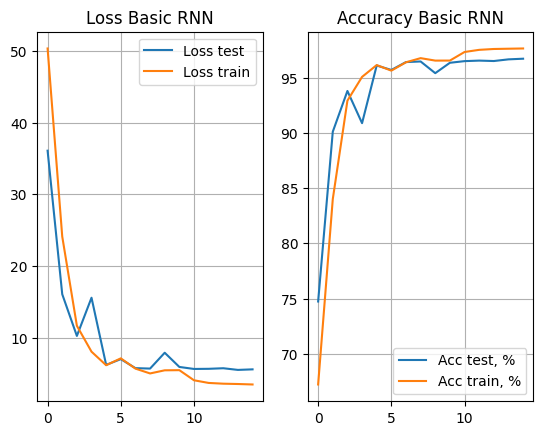

In [19]:
train(model, Train, Test, optimizer, 'Basic RNN', verbose=True)

Полученная модель хорошо справляется с дешифровкой кода Цезаря, она не пытается изменить пробелы и символы none но первые символы угадываются некорректно, так как ещё нет контекста